# Multiple Type Experiment

In [1]:
import warnings;
warnings.filterwarnings('ignore');

from time import sleep
from tqdm.auto import tqdm

import sys
import importlib
import numpy as np
import nbformat
# import plotly.express
# import plotly.express as px
import pandas as pd
import cvxpy as cp
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import seaborn as sns

from solvers import get_individual_utility, generate_cvxpy_solve, verify_fairness, get_utility, offline_opt, fixed_threshold, hope_online, hope_full, hope_guardrail
from radar_plot import *

In [2]:
data = []
num_types = 5
num_resources = 3
weights = np.asarray([[1, 2, 3], [1, 3, 2], [4, 1, 5], [1, 2, .5], [3, 7, 5]])
sum_of_rows = weights.sum(axis=1)

weights = weights / sum_of_rows[:, np.newaxis]

algo_list = {'Fixed Threshold': fixed_threshold,
             'Hope Guardrail $L_T = 1/2$': lambda a,b,c,d,e,f,g: hope_guardrail(a,b,c,d,e,f,1/2,g),
             'Hope Guardrail $L_T = 1/3$': lambda a,b,c,d,e,f,g: hope_guardrail(a,b,c,d,e,f,1/3,g),
#              'Hope Online': hope_online,
#              'Hope Full': hope_full}
            }

num_algo = len(algo_list)

num_iterations = 5
# num_iterations = 20

act_mean = np.asarray([1.5, 2.5, 3.5, 4.5, 5.5])
mean_size = act_mean
stdev_size = mean_size

utility = 'leontief_epsilon'

In [3]:
num_groups = np.logspace(2, 10, base=2, num=15).astype(int)
epsilon_grid = np.linspace(0, .2, 10)
# num_groups = np.logspace(2, 5, base=1.5, num=5).astype(int)

for epsilon in tqdm(epsilon_grid):
    for n in tqdm([5, 15, 50, 100, 500]):
        n = int(n)
        print(f'Num Locations: {n}, Epsilon: {epsilon}')
        # pected_size = mean_size
    #     budget = np.asarray([np.sum(act_mean)*n, np.sum(act_mean)*n, np.sum(act_mean)*n])
        budget = np.asarray([np.dot(act_mean, weights[:,0])*n, np.dot(act_mean, weights[:,1])*n, np.dot(act_mean, weights[:,2])*n])


        mean = np.array([mean_size,]*n)
        stdev = mean

        for i in range(num_iterations):
            # size = np.random.choice(size=(n, num_types), a=[1.,2.], p=[1/2, 1/2])
            # size = 1+np.maximum(0, np.random.normal(size=(n, num_types), loc = mean_size-1, scale = .2))
            size = 1 + np.random.poisson(size = (n, num_types), lam = mean_size - 1)
            # print('Size: ' + str(size))
            total_num_types = np.sum(size, axis=0)
            prob, solver = generate_cvxpy_solve(num_types, num_resources, utility)


            epsilon_opt = offline_opt(budget, size, weights, solver)

            true_prob, true_solver = generate_cvxpy_solve(num_types, num_resources, 'leontief')
            true_opt = offline_opt(budget, size, weights, solver)


            index = 0
            for algo in algo_list:


                sol, waste = algo_list[algo](budget, size, mean, stdev, weights, solver, epsilon)

                waste, envy, proportionality, c_envy, orig_envy = verify_fairness(weights, sol, np.asarray(size), np.asarray(budget), utility, epsilon_opt, epsilon)


                c_envy_true_u_epsilon = 0
                c_envy_true_u_zero = 0
                for t in range(size.shape[0]):
                    for typ in range(size.shape[1]):
                        eps_val = get_individual_utility(weights[typ], sol[t, typ], 'leontief') - get_individual_utility(weights[typ], epsilon_opt[t, typ], 'leontief')
                        zero_val = get_individual_utility(weights[typ], sol[t, typ], 'leontief') - get_individual_utility(weights[typ], true_opt[t, typ], 'leontief')
                        c_envy_true_u_epsilon = max(c_envy_true_u_epsilon, np.abs(eps_val))
                        c_envy_true_u_zero = max(c_envy_true_u_zero, np.abs(zero_val))




    #             alloc_diff[index, i, :, :, :] = opt - sol
                data_dict = {'NumGroups': n, 'Epsilon': epsilon, 'Algorithm': algo, 'Norm': 'Epsilon_Utility_Hindsight_Envy', 'Value': envy}
                data.append(data_dict)
                data_dict = {'NumGroups': n, 'Epsilon': epsilon, 'Algorithm':algo, 'Norm': 'Proportionality', 'Value': proportionality}
                data.append(data_dict)
                data_dict = {'NumGroups': n, 'Epsilon': epsilon, 'Algorithm':algo, 'Norm': 'Waste', 'Value': waste}
                data.append(data_dict)
                data_dict = {'NumGroups': n, 'Epsilon': epsilon, 'Algorithm':algo, 'Norm': 'Epsilon_Utility_Counterfactual_Envy', 'Value': c_envy}
                data.append(data_dict)
                data_dict = {'NumGroups': n, 'Epsilon': epsilon, 'Algorithm':algo, 'Norm': 'True_Utility_Epsilon_Counterfactual_Envy', 'Value': c_envy_true_u_epsilon}
                data.append(data_dict)
                data_dict = {'NumGroups': n, 'Epsilon': epsilon, 'Algorithm':algo, 'Norm': 'True_Utility_Zero_Counterfactual_Envy', 'Value': c_envy_true_u_zero}
                data.append(data_dict)
                data_dict = {'NumGroups': n, 'Epsilon': epsilon, 'Algorithm':algo, 'Norm': 'True_Utility_Hindsight_Envy', 'Value': c_envy_true_u_zero}
                data.append(data_dict)




  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Num Locations: 5, Epsilon: 0.0
Num Locations: 15, Epsilon: 0.0
Sizes!
[ 27.80947502  49.29861481  65.73148641  88.48469324 104.91756485]
Weights!
[[0.16666667 0.33333333 0.5       ]
 [0.16666667 0.5        0.33333333]
 [0.4        0.1        0.5       ]
 [0.28571429 0.57142857 0.14285714]
 [0.2        0.46666667 0.33333333]]
Budget!
[ 66.78571429 108.57142857  87.14285714]
Solve failed retyring verbose


KeyboardInterrupt: 

In [4]:
# df = pd.DataFrame.from_records(data)
# df.to_csv('./data_leontief/multi_poisson.csv', index=False)
df = pd.read_csv('./data_leontief/multi_poisson.csv')

Index(['NumGroups', 'Epsilon', 'Algorithm', 'Norm', 'Value'], dtype='object')


AttributeError: 'NoneType' object has no attribute 'remove'

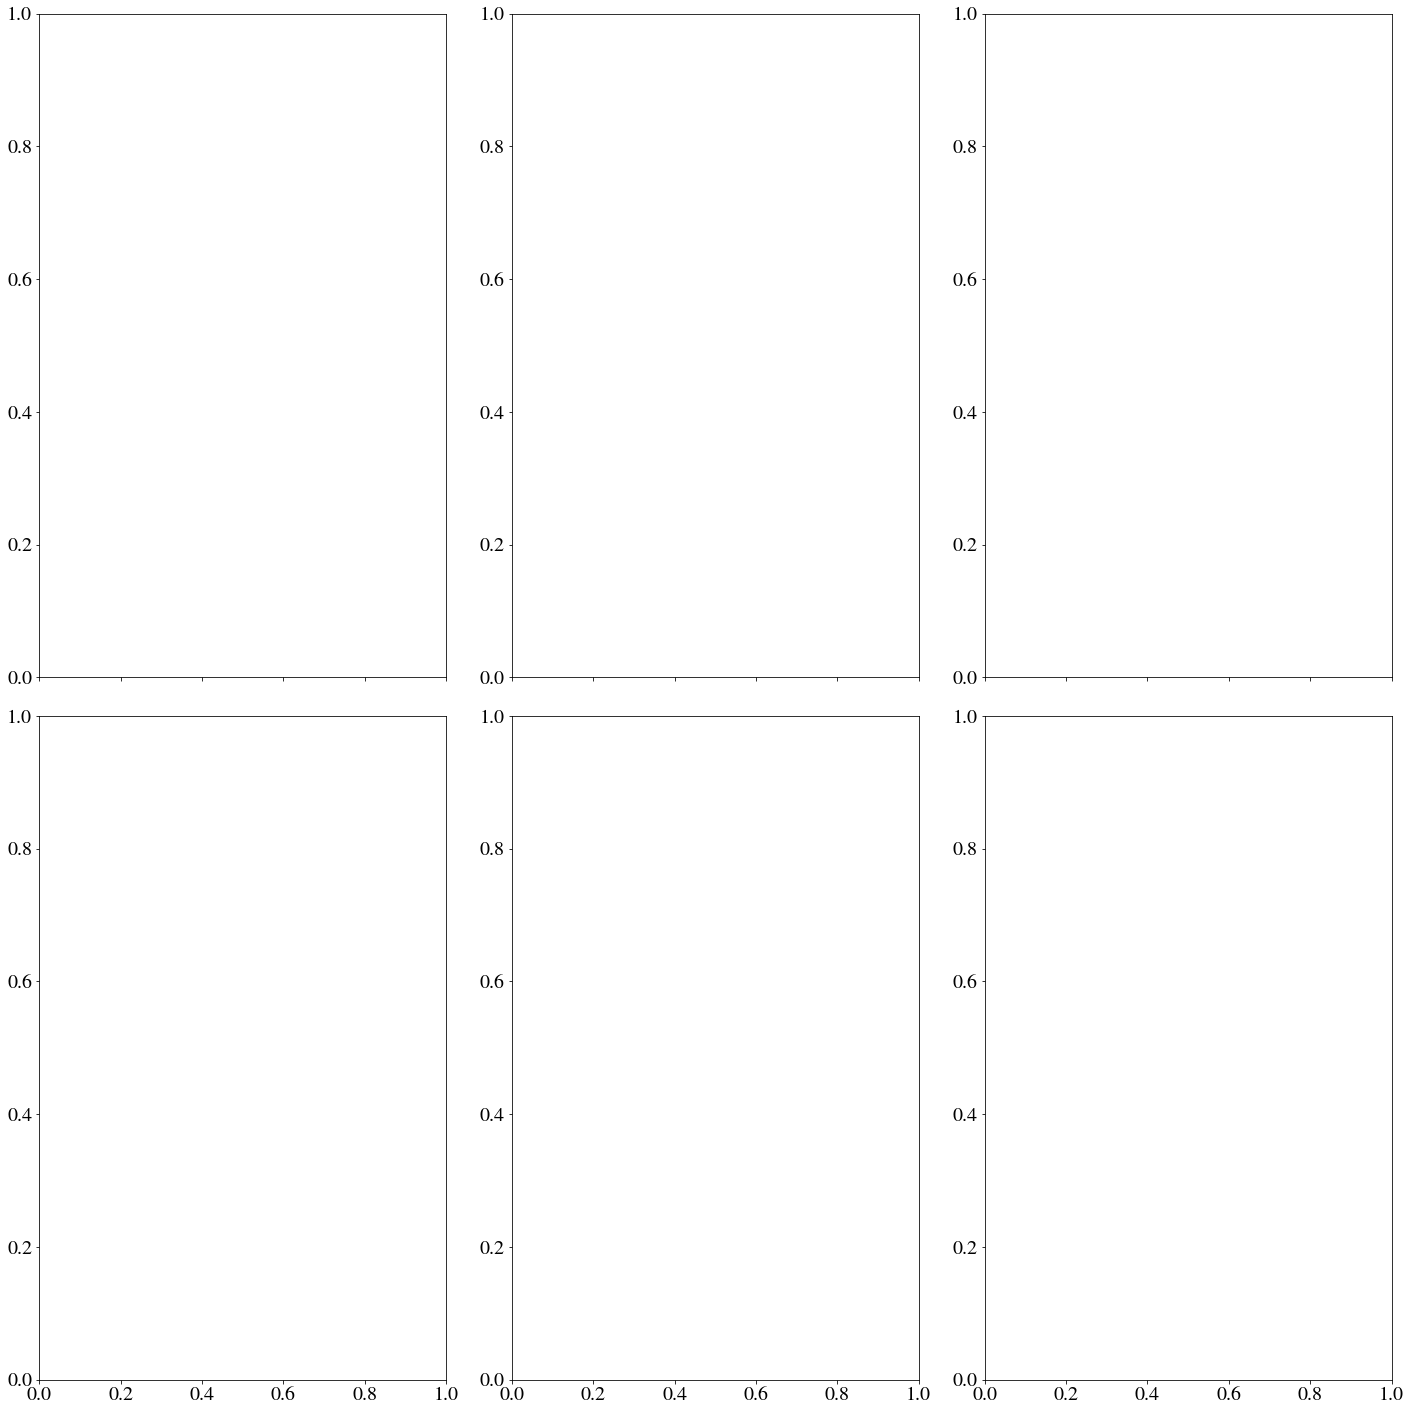

In [5]:
df = pd.read_csv('./data_leontief/multi_poisson.csv')
fixed_t = False

if fixed_t:
    ylabel = 'Epsilon'
    y_plot = 'Epsilon'
    t = 105
    df = df[df.NumGroups == t]
else:
    ylabel = 'Number of Rounds'
    y_plot = 'NumGroups'
    eps = 0.2222222222222222
    df = df[df.Epsilon == eps]
    



fixed_T = 50

print(df.columns)
df = df.assign(Algorithm = lambda df: df.Algorithm.replace({'fixed_threshold': 'Fixed Threshold', 'hope_guardrail_13': 'Guarded Hope 1/3', 'hope_guardrail_12': 'Guarded Hope 1/2'}))



plt.style.use('PaperDoubleFig.mplstyle.txt')
# Make some style choices for plotting 
# colorWheel =['#2bd1e5',
#             '#281bf5',
#              '#db1bf5',
#              '#F5CD1B',
#             '#FF5733','#9cf51b',]
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]


#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#plt.figure(figsize=(20,10))
#plt.title('Simple Distribution L1')
#sns.lineplot(x='NumGroups', y='value', hue='variable', data=df[df.Norm == 'L1'])

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]

# fig = plt.figure(figsize=(20,6))
# plt.rc('text', usetex=True)



fg, axs = plt.subplots(2,3, sharex='all', figsize=(20,20))
sns.lineplot(x=y_plot, y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)],
                     data=df[df.Norm == 'Epsilon_Utility_Hindsight_Envy'], ax = axs[0,0], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)
sns.lineplot(x=y_plot, y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)],
                     data=df[df.Norm == 'Epsilon_Utility_Counterfactual_Envy'], ax = axs[0,1], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)
sns.lineplot(x=y_plot, y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)],
                     data=df[df.Norm == 'True_Utility_Epsilon_Counterfactual_Envy'], ax = axs[0,2], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)
sns.lineplot(x=y_plot, y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)],
                     data=df[df.Norm == 'True_Utility_Zero_Counterfactual_Envy'], ax = axs[1,0], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)
sns.lineplot(x=y_plot, y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)],
                     data=df[df.Norm == 'True_Utility_Hindsight_Envy'], ax = axs[1,1], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)
sns.lineplot(x=y_plot, y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Waste'], ax = axs[1,2], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)

# sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
#              data=df[df.Norm == 'Hindsight_Envy'], ax = axs[2], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
#             ci = None)



axs[0,0].get_legend().remove()
axs[0,0].set_title('Epsilon Utility Hindsight Envy')
axs[0,0].set_xlabel(ylabel)

axs[0,1].set_title('Epsilon Utility Counterfactual Envy')
axs[0,1].set_xlabel(ylabel)
axs[0,1].get_legend().remove()


axs[0,2].set_title('True Utility Epsilon Counterfactual Envy')
axs[0,2].set_xlabel(ylabel)
axs[0,2].get_legend().remove()


axs[1,0].set_title('True Utility Zero Counterfactual Envy')
axs[1,0].set_xlabel(ylabel)
axs[1,0].get_legend().remove()


axs[1,1].set_title('True Utility Zero Counterfactual Envy')
axs[1,1].set_xlabel(ylabel)
axs[1,1].get_legend().remove()


axs[1,2].set_title('True Utility Hindsight Envy')
axs[1,2].set_xlabel(ylabel)
axs[1,2].get_legend().remove()


# axs[2].get_legend().remove()
# axs[2].set_ylabel(r'$Envy$')
# axs[2].set_xlabel('Number of Rounds')


axs[1,2].legend(ncol = 1, loc= 'upper right')




plt.show()
# fg.savefig('./figures/synthetic_multi.pdf', bbox_inches = 'tight',pad_inches = 0.01, dpi=900)